<h1>RNA Folding Transformer Encoder Model

<h3>Import and Load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout 
from keras.optimizers import AdamW
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import keras
import keras_nlp
from keras import layers

In [8]:
train = pd.read_csv('train_data_QUICK_START.csv')
test = pd.read_csv('test_sequences.csv')

<h3>Preprocessing


In [9]:
df_2A3 = train[train['experiment_type'] == '2A3_MaP']
df_DMS = train[train['experiment_type'] == 'DMS_MaP']

In [10]:
# Add padding to sequence such that they are all 457 in length
def pad_sequence(sequence, max_length=206, padding_value="Z"):
  # Calculate how many padding values are needed
  padding_length = max_length - len(sequence)
  # Create the padded sequence
  padded_sequence = list(sequence) + [padding_value] * padding_length
  return padded_sequence

def encode_nuc(nuc):
  nuc_map = {
      "A": [1],
      "C": [2],
      "G": [3],
      "U": [4],
      "Z": [5]
  }
  try:
      return nuc_map[nuc]
  except:
      print(f"Error at nucleotide {nuc}")

def encode_sequence(sequence):
  try:
    return [encode_nuc(s) for s in sequence]
  except:
    print(f"Error at sequence {sequence}")

# padded 2A3 and DMS
encoded_2A3train = df_2A3.loc[:, ['sequence_id', 'sequence']]
encoded_2A3train['padded_sequence'] = encoded_2A3train['sequence'].apply(pad_sequence)
encoded_DMStrain = df_DMS.loc[:, ['sequence_id', 'sequence']]
encoded_DMStrain['padded_sequence'] = encoded_DMStrain['sequence'].apply(pad_sequence)

#fill 2A3 and DMS reactivities 
reactivities2A3 = df_2A3.iloc[:, 4:210]
reactivities2A3.fillna(0, inplace = True)
reactivitiesDMS = df_DMS.iloc[:, 4:210]
reactivitiesDMS.fillna(0, inplace = True)

# merge 2A3 and DMS
#merge concat (sequences with reactivities)
sequence2A3 = pd.concat([encoded_2A3train, reactivities2A3], axis=1)
sequenceDMS = pd.concat([encoded_DMStrain, reactivitiesDMS], axis=1)
#merge concat 2A3 and DMS
df = pd.concat([sequence2A3,sequenceDMS], ignore_index = True)
#clip values less than 0 = 0, since we know those are errors/ should be 0 at minimum. Values greater than 1 = 1
num = df._get_numeric_data()
num[num < 0] = 0
num[num > 1] = 1

In [11]:
#Encode Sequences
df['encoded_sequence'] = df['padded_sequence'].apply(encode_sequence)

In [12]:
sequences = df['encoded_sequence']
reactivities = df.iloc[:, 3:209]

<h3> Split Training and Testing Data

In [13]:
X = sequences
Y = reactivities

In [14]:
#Split data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(268492,) (268492, 206)
(67124,) (67124, 206)


In [15]:
# Convert np arrays to tensors
X_train_array = np.array([np.array(seq) for seq in X_train])
X_test_array = np.array([np.array(seq) for seq in X_test])
X_train = tf.convert_to_tensor(X_train_array)
X_test = tf.convert_to_tensor(X_test_array)
Y_train = tf.convert_to_tensor(Y_train.values)
Y_test = tf.convert_to_tensor(Y_test.values)

<h3> Set Up Transformer Block, Multihead Attention, and Layer Normalization

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.01):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.feedf = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layer1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attention_output = self.att(inputs, inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layer1(inputs + attention_output)
        feedf_output = self.feedf(out1)
        feedf_output = self.dropout2(feedf_output)
        return self.layer2(out1 + feedf_output)

<h3> Set Up Tokens and Position Embedding

In [17]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        position = tf.range(start=0, limit=maxlen, delta=1)
        position = self.pos_emb(position)
        x = self.token_emb(x)
        return x + position

<h3> Train Model on Test Data

In [18]:
#Hyperparameters
vocab_size = 206
maxlen = 206
embed_dim = 128  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(206,1))
embed_layer = PositionEmbedding(maxlen, vocab_size, embed_dim)
x = embed_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.20)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.20)(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(206, activation="softmax")(x)

In [47]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = AdamW(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics = ["MeanAbsoluteError"])
history = model.fit(X_train, Y_train, batch_size=8, epochs=5)

Epoch 1/5
33562/33562 ━━━━━━━━━━━━━━━━━━━━ 3875s 115ms/step - MeanAbsoluteError: 0.1504 - loss: 0.1504
Epoch 2/5
33562/33562 ━━━━━━━━━━━━━━━━━━━━ 3273s 98ms/step - MeanAbsoluteError: 0.1504 - loss: 0.1504
Epoch 3/5
33562/33562 ━━━━━━━━━━━━━━━━━━━━ 3249s 97ms/step - MeanAbsoluteError: 0.1503 - loss: 0.1503
Epoch 4/5
33562/33562 ━━━━━━━━━━━━━━━━━━━━ 3261s 97ms/step - MeanAbsoluteError: 0.1504 - loss: 0.1504
Epoch 5/5
33562/33562 ━━━━━━━━━━━━━━━━━━━━ 3294s 98ms/step - MeanAbsoluteError: 0.1504 - loss: 0.1504


<h3> Plot Loss per Epoch

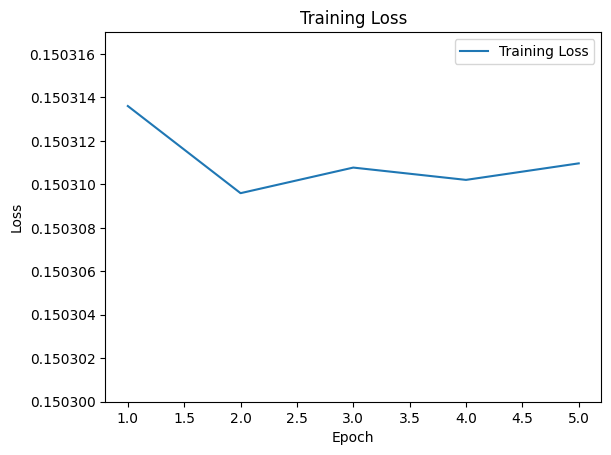

In [86]:
plt.plot(range(1, 6), history.history['MeanAbsoluteError'], label='Training Loss')
plt.ylim(0.15030, .150317)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h3> Evaluate on Testing Data

In [55]:
loss = model.evaluate(X_test, Y_test, batch_size=100)
print(f"Mean Absolute Error on Test Set: {loss}")

672/672 ━━━━━━━━━━━━━━━━━━━━ 423s 628ms/step - MeanAbsoluteError: 0.1502 - loss: 0.1502
Mean Absolute Error on Test Set: [0.15019378066062927, 0.15020279586315155]
